In [292]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *
import time

from simulator import *
from utils import *
from physics import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
omega_r = 1e+10
simulation_name = "test"

Lx = 5 * 1e-9 #m
Ly = 5 * 1e-9 #m
Nx, Ny = 10, 10  # Numero di nodi in x e y

dt = 1e-13
simulation_time = 1000e-13
boundaries_type = "absorbing"

backend = "cpu"
poisson_tolerance = 1e-13
poisson_method = "gauss_seidel"#"gauss_seidel" #"jacobi"

In [309]:
norm = Normalization(omega_r=omega_r)
# Lx, Ly = norm.to_nondim_length(Lx), norm.to_nondim_length(Lx)  # Dimensioni del dominio
dx, dy = Lx / Nx, Ly / Ny  # Passo della griglia

# CFL_condition, CFL = check_CFL_condition(dt, dx)
# if not CFL_condition:
#     print("Condizione CFL non rispettata, ", CFL)

# dt = norm.to_nondim_time(dt)
# simulation_time = norm.to_nondim_time(simulation_time)

space = Space(simulation_name, Lx, Ly, Nx, Ny, simulation_time, dt, boundaries_type = boundaries_type, normalization = norm, backend= backend)
steps = space.steps
space.save_frequency = 1
space.poisson_tolerance = poisson_tolerance
space.verbose = False
space.poisson_method = poisson_method

In [310]:
space.create_new_specie("electron", charge = -e, mass = m_e, num_particles= 200)
#space.create_new_specie("proton", charge = e, mass = 1836*m_e, num_particles= 100000) #, distribution= "maxwell-boltzmann", temperature = 300

#space.add_rectangle_object(0.45 *Lx, 0.55*Lx, 0.45*Lx, 0.55*Ly, solid= False, potential=1)
# space.add_rectangle_object(0.35 *Lx, 0.85*Lx, 0.15*Lx, 0.25*Ly, solid= False, potential=-0.1)
space.add_rectangle_object(0.25 *Lx, 0.35*Lx, 0.45*Lx, 0.55*Ly, solid= True, type="absorbing")

#space.define_constant_magnetic_field(0.25 *Lx, 0.85*Lx, 0.25*Lx, 0.85*Ly, 0.01)

In [311]:
start = time.time()
with torch.no_grad():
    for step in tqdm(range(steps), unit=" step", leave=True):
        #draw_histogram_xy(particles_position)
        space.update()
        
end = time.time()
print(f"Elapsed time: {end - start}")

  1%|          | 7/1000 [00:02<06:37,  2.50 step/s]


KeyboardInterrupt: 

False

[INFO] Caricati i dataset dal file test: ['charge_register', 'fields_chronology', 'fixed_potential_mask', 'fixed_potential_value', 'grid_chronology', 'kinetic_energy_chronology', 'mass_register', 'mechanic_energy_chronology', 'name_register', 'particles_active_chronology', 'particles_position_chronology', 'particles_specie_chronology', 'particles_velocity_chronology', 'potential_energy_chronology', 'solid_mask', 'solid_type']


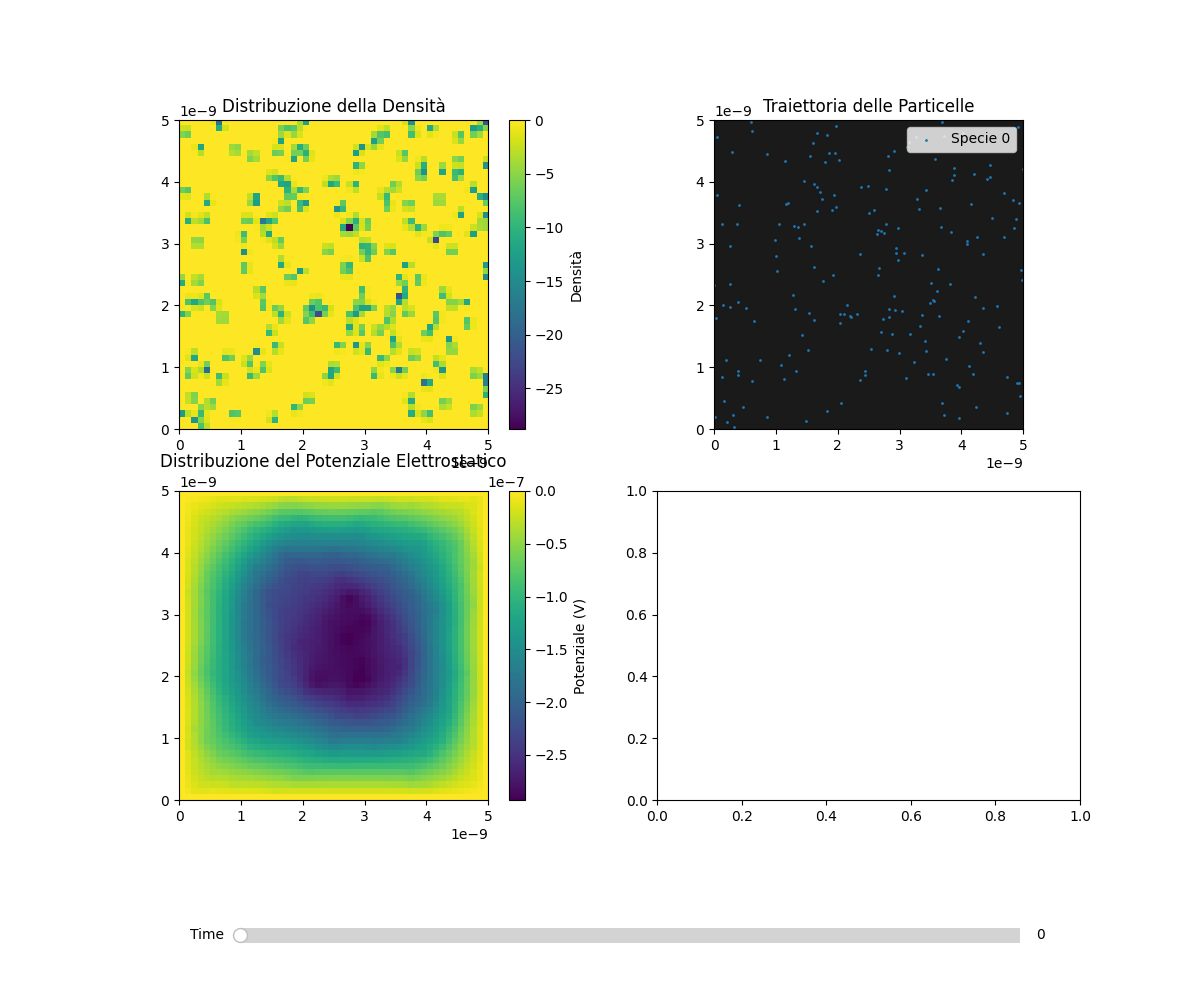

In [312]:
simulation = load_simulation(simulation_name, device= backend)

%matplotlib widget
dynamic_slider(simulation, Lx, Ly)

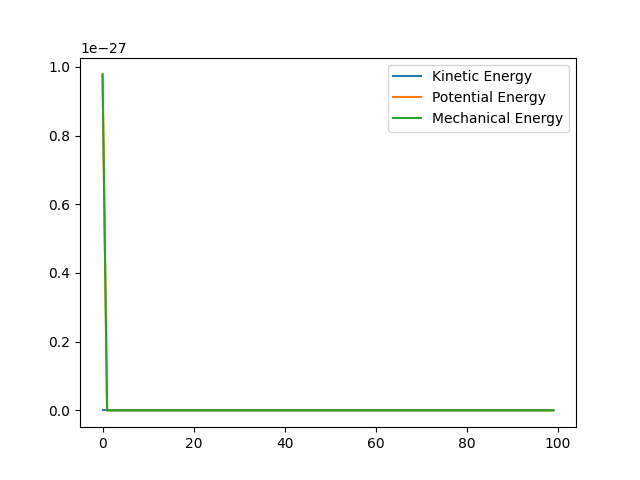

In [291]:
plt.close()
plt.figure()
plt.plot(kinetic_energy_chronology, label="Kinetic Energy")
plt.plot(potential_energy_chronology, label="Potential Energy")
plt.plot(mechanic_energy_chronology, label="Mechanical Energy")
plt.legend()
plt.show()

In [230]:
with profiler.profile(record_shapes=True) as prof:
    space.update()
print(prof.key_averages().table(sort_by="cuda_time_total" if device == "cuda" else "cpu_time_total"))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::index         6.98%       2.458ms        17.22%       6.065ms      40.164us           151  
                aten::nonzero         7.94%       2.795ms         9.23%       3.249ms      12.033us           270  
                  aten::empty         1.23%     433.500us         1.23%     433.500us       0.829us           523  
            aten::as_strided_         0.61%     214.300us         0.61%     214.300us       0.794us           270  
                 aten::select         4.79%       1.686ms         5.54%       1.949ms       3.367us           579  
             aten::as_strided         3.57%       1.258ms         3.57% 